In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi

# Basic KLIP Subtraction Tutorial for JWST Simualted Data

This is a simple notebook where we will just remove the glare of the star (no characterizing of the planets). This allows us to get a sense of the data. We will reduce it in three ways: ADI, RDI, and ADI+RDI. ADI takes advantage of telescope rolls (where the planet compoanions rotate, but the stellar PSF stays constant) to distinguish the light from the star from the planet. RDI uses another star (of similar spectral type, but with no planets around it) to use as the model of the star to subtract off of. We can also combine these technqiues. 

## Read in the data

There is data taken of the science target at two telescope roll angles. There is also data taken on a reference star (without companions) that we can use to model the stellar PSF. Lastly, there is data where the star is moved off of the coronagraph so that we can use this for photometric calibration (will not happen in this notebook). Here, we don't simulate saturation, but for real JWST, we will place the star behind an ND filter and we will know the ND throughput. 

(6, 101, 101)
(6, 101, 101)
(54, 101, 101)
(6, 101, 101)


Text(0.5, 1.0, 'Unocculted PSF')

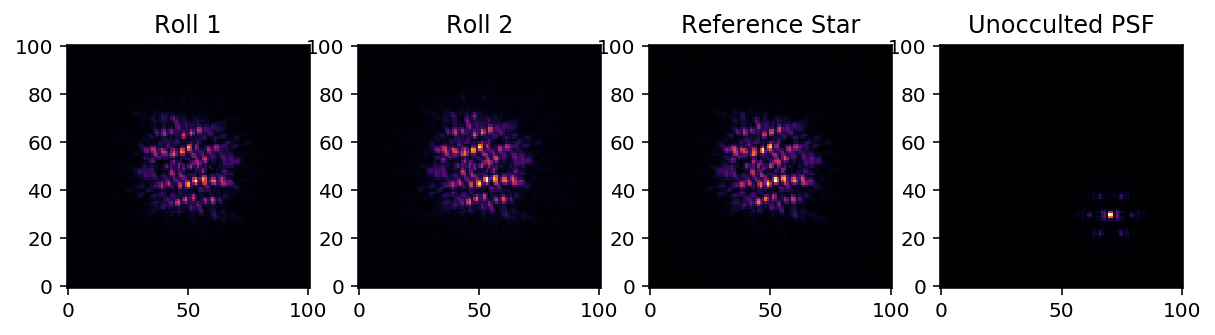

In [2]:
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data
    print(roll1_cube.shape)
    
# read in roll 2
with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data   
    print(roll2_cube.shape)
    
# read in ref star
with fits.open("old_simulated_data/NIRCam_refs_SGD_{0}.fits".format(filtername)) as hdulist:
    ref_cube = hdulist[0].data 
    print(ref_cube.shape)
    
# read in unocculted PSF
with fits.open("old_simulated_data/NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    print(psf_cube.shape)  
    
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,4,1)
ax1.imshow(roll1_cube[0], interpolation="nearest", cmap="inferno")
ax1.invert_yaxis()
ax1.set_title("Roll 1")

ax2 = fig.add_subplot(1,4,2)
ax2.imshow(roll2_cube[0], interpolation="nearest", cmap="inferno")
ax2.invert_yaxis()
ax2.set_title("Roll 2")
plt.savefig('psf.png')

ax3 = fig.add_subplot(1,4,3)
ax3.imshow(ref_cube[0], interpolation="nearest", cmap="inferno")
ax3.invert_yaxis()
ax3.set_title("Reference Star")

ax4 = fig.add_subplot(1,4,4)
ax4.imshow(psf_cube[0], interpolation="nearest", cmap="inferno")
ax4.invert_yaxis()
ax4.set_title("Unocculted PSF")

## Read in the Data into pyKLIP

We will use the Generic Data interface for simulated JWST data since we don't have data with proper headers and such. And we will combine the two science rolls together

In [4]:
# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees, this is the right sign (trust me)
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

# create the GenericData object. This will standardize the data for pyKLIP
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False # get the right handedness of the data

## Run KLIP-ADI

This only uses images taken at other roll angles. We will use KLIP-ADI reductions for our forward modelling to extract out the flux and position of the planets, as pyKLIP-RDI forward modelling is not yet supported (will be done soon)

We will break up the image into 9 concentric annuli and each annuli into 4 azimuthal sectors. We will run KLIP on each of these sectors. A free parameter of KLIP is the number of PCA modes used to reconstruct the stellar PSF (the `numbasis` keyword). We will try a bunch to see which is best.

In [5]:
parallelized.klip_dataset(dataset, outputdir="./", fileprefix="pyklip-f300m-ADI-k50a9s4m1", annuli=9, 
                          subsections=4, numbasis=[1,5,10,20,50], mode="ADI", movement=1)

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /Users/jeaadams/JWST_PIPE


/Users/jeaadams/Follete-group/Follette-group/wrapperUpdate/pyklip/pyklip/parallelized.py:1543: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))


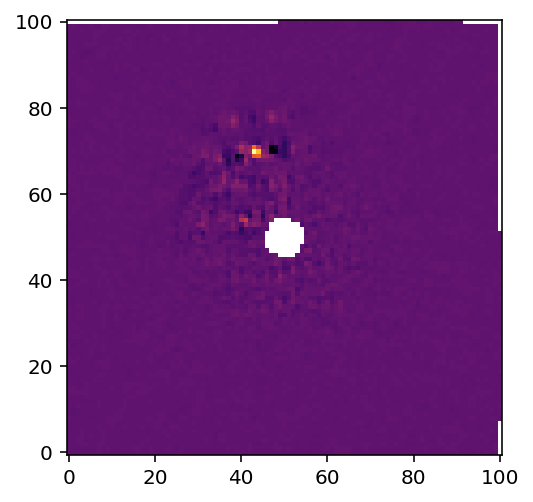

In [6]:
# Plot this reduced data cube. The 3rd axis is the number of PCA modes used
with fits.open("pyklip-f300m-ADI-k50a9s4m1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data
    
plt.figure()
# plot the KL10 Cube (index of 2)
plt.imshow(adi_cube[2], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()

## pyKLIP RDI Reduction 

### Set up PSF Library
To use RDI, we need to put all of our reference images and science images into a PSF library for pyKLIP to access. The PSF library tells us what PSFs we can use of other stars to model the stellar PSF.

We assume all the simualted data is aligned to the image center

In [6]:
# combine both science target and reference target images into a psf library array
psflib_imgs = np.append(ref_cube, full_seq, axis=0)
ref_filenames = ["ref_{0}".format(i) for i in range(ref_cube.shape[0])]
psflib_filenames = np.append(ref_filenames, filenames, axis=0)
# all frames aligned to image center (Which are the same size)
ref_center = np.array(ref_cube[0].shape)/2

# make the PSF library
# we need to compute the correlation matrix of all images vs each other since we haven't computed it before
psflib = rdi.PSFLibrary(psflib_imgs, ref_center, psflib_filenames, compute_correlation=True)

# save the correlation matrix to disk so that we also don't need to recomptue this ever again
# In the future we can just pass in the correlation matrix into the PSFLibrary object rather than having it compute it
psflib.save_correlation("corr_matrix_{0}.fits".format(filtername), clobber=True)

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\jwang\OneDrive\Research\JWST\nircam_sims


c:\users\jwang\onedrive\gpi\klip\pyklip\pyklip\parallelized.py:1415: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))/np.nanmean(pixel_weights, axis=(1,2))


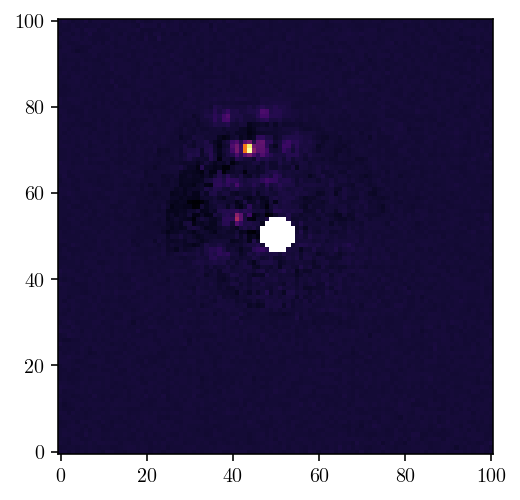

In [7]:
# prepare the PSF Library to run on our science dataset
psflib.prepare_library(dataset)

# Run pyKLIP RDI
parallelized.klip_dataset(dataset, outputdir="./", fileprefix="pyklip-f300m-RDI-k50a9s4", annuli=9, 
                          subsections=4, numbasis=[1,5,10,20,50], mode="RDI", psf_library=psflib)

# Open and plot
with fits.open("pyklip-f300m-RDI-k50a9s4-KLmodes-all.fits") as hdulist:
    rdi_cube = hdulist[0].data
    
plt.figure()
# plot the KL20 Cube (index of 3)
plt.imshow(rdi_cube[3], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()


## Now run pyKLIP ADI+RDI

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\jwang\OneDrive\Research\JWST\nircam_sims


c:\users\jwang\onedrive\gpi\klip\pyklip\pyklip\parallelized.py:1415: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))/np.nanmean(pixel_weights, axis=(1,2))


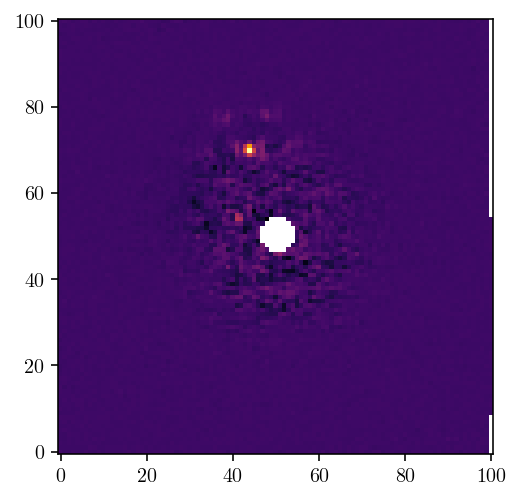

In [8]:
psflib.prepare_library(dataset)

parallelized.klip_dataset(dataset, outputdir="./", fileprefix="pyklip-f300m-ADI+RDI-k50a9s4", annuli=9, 
                          subsections=4, numbasis=[1,5,10,20,50], mode="ADI+RDI", psf_library=psflib)


with fits.open("F330M_reduction/pyklip-ADI+RDI-k50a9s4-KLmodes-all.fits") as hdulist:
    ardi_cube = hdulist[0].data
    hdulist.close()
    
plt.figure()
# plot the KL20 Cube (index of 3)
plt.imshow(ardi_cube[3], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()

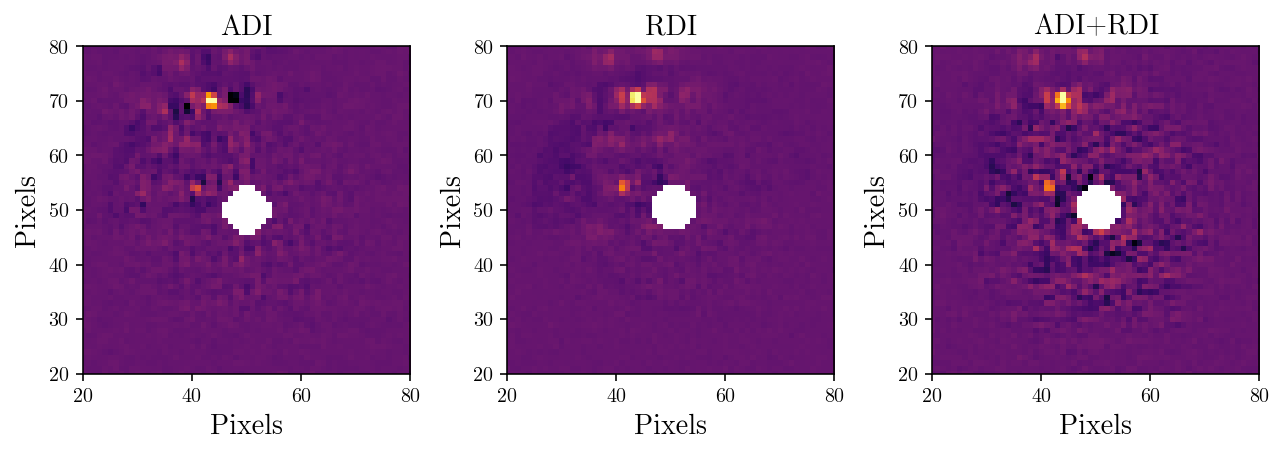

In [9]:
# Comparison plot
minval = np.nanpercentile(adi_cube[2], 0.01)
maxval = np.nanpercentile(adi_cube[2], 99.99)

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1,3,1)
ax.imshow(adi_cube[2], interpolation='nearest', cmap='inferno', vmin=minval, vmax=maxval)
ax.set_xlim([20,80])
ax.set_ylim([20,80])
ax.set_title("ADI", fontsize=14)
ax.set_xlabel("Pixels", fontsize=14)
ax.set_ylabel("Pixels", fontsize=14)

ax = fig.add_subplot(1,3,2)
ax.imshow(rdi_cube[2], interpolation='nearest', cmap='inferno', vmin=minval, vmax=maxval)
ax.set_xlim([20,80])
ax.set_ylim([20,80])
ax.set_title("RDI", fontsize=14)
ax.set_xlabel("Pixels", fontsize=14)
ax.set_ylabel("Pixels", fontsize=14)

ax = fig.add_subplot(1,3,3)
ax.imshow(ardi_cube[2], interpolation='nearest', cmap='inferno', vmin=minval, vmax=maxval)
ax.set_xlim([20,80])
ax.set_ylim([20,80])
ax.set_title("ADI+RDI", fontsize=14)
ax.set_xlabel("Pixels", fontsize=14)
ax.set_ylabel("Pixels", fontsize=14)

plt.tight_layout()